# Соберем сверточную нейронную сеть LiNet5

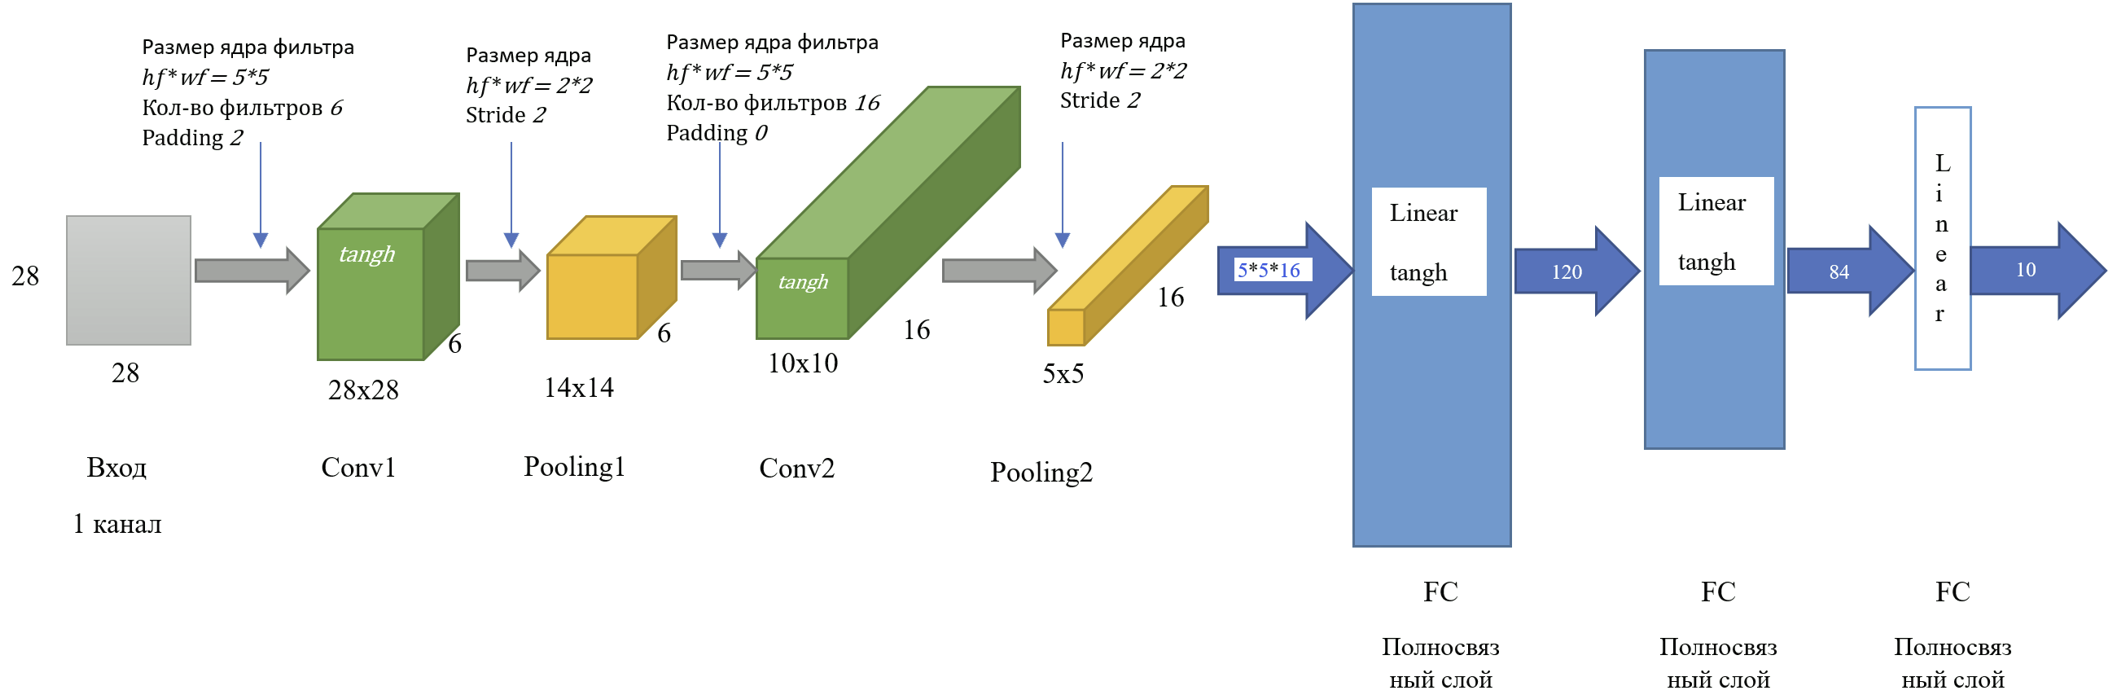


В архитектуре нейронной сети, показанной выше:

**Слой Conv1** представляет собой сверточный слой с шестью картами признаков, размер которых составляет $28 \times 28$, функция активации $tangh$;

**Слой Pooling1** – это слой подвыборки (polling) с шестью картами признаков, размер которых составляет $14 \times 14$, функция активации $AvgPooling$;

**Слой Conv2** представляет собой сверточный слой с шестнадцатью характеристическими картами (слоями), размер которых составляет $10 \times 10$, функция активации $tangh$;

**Слой Pooling2** является слоем подвыборки с шестнадцатью характеристическими картами, размер которых составляет $5 \times 5$, функция активации $AvgPooling$;

**Слой FC** представляет собой полносвязанный слой, вход $5 \times 5 \times 16$ нейронов (признаков), выход $120$ нейронов, функция активации $tangh$;

**Слой FC** представляет собой полносвязанный слой, вход $120$ нейронов (признаков), выход $84$ нейрона, функция активации $tangh$;

**Слой FC** представляет собой полносвязанный слой, вход $84$ нейронов (признаков), выход $10$ нейронов;



In [1]:
# импортируем библиотеки

import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
# это для cuda .
#torch.cuda.memory_summary(device=None, abbreviated=True)

In [3]:
# это для cuda. принудительно освобождение памяти, что иногда, но очень редко, помогает решить проблему с отказом
# cuda использовать память
#import gc
#gc.collect()

#torch.cuda.empty_cache()

In [3]:
# будем использовать встроенные датасеты торча.
# полный список - тут https://pytorch.org/vision/stable/datasets.html


import torchvision.datasets

In [4]:
# загружаем сразу в трайн и тест
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)


100%|██████████| 9.91M/9.91M [00:03<00:00, 3.07MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 210kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 1.86MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.02MB/s]


In [5]:
# формируем датасеты для обучения, тестирования, целевые переменные
X_train = MNIST_train.data
y_train = MNIST_train.targets
X_test = MNIST_test.data
y_test = MNIST_test.targets

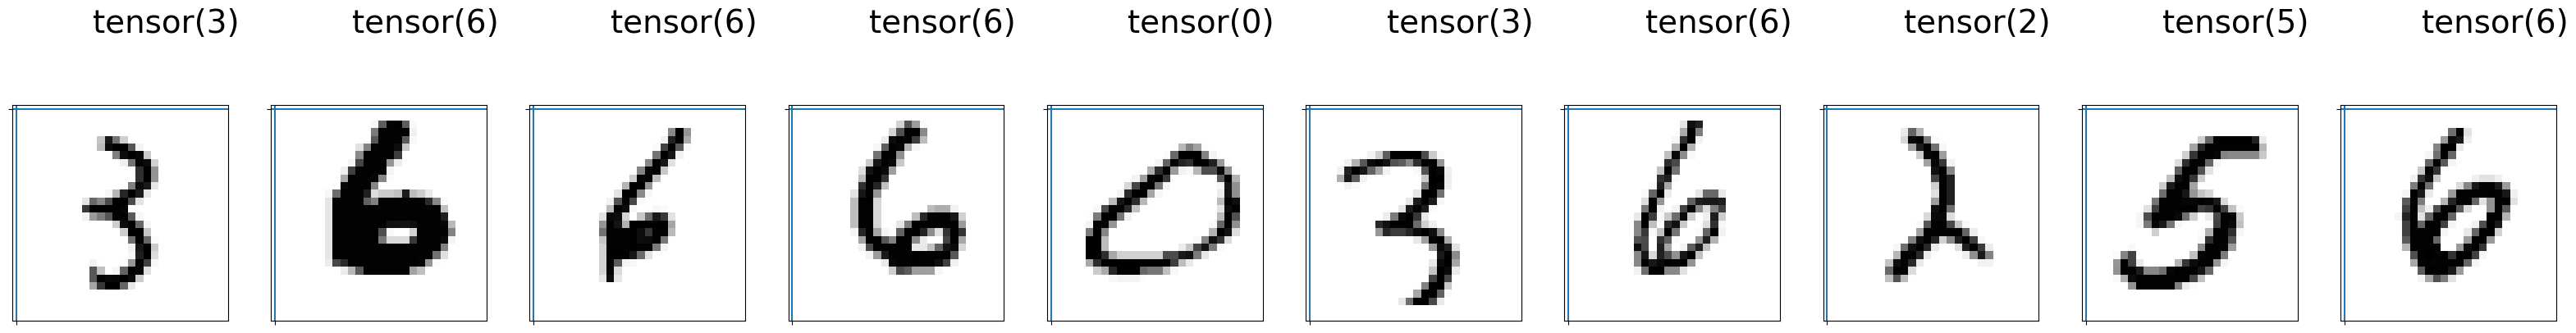

In [6]:
# посмотрим, что пришло

import numpy as np
import matplotlib.pyplot as plt

# посмотрим какие-то произвольные изображения из датасета
count = 0
sample_size = 10  # сколько картинок будем смотреть
plt.figure(figsize=(40, 20))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=28)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

In [7]:
# сколько изображений в трейне и тесте
len(y_train), len(y_test)

(60000, 10000)

image:
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  42, 118, 219,
         166, 118, 118,   6,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 103, 242, 254, 254,
         254, 254, 254,  66,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0, 

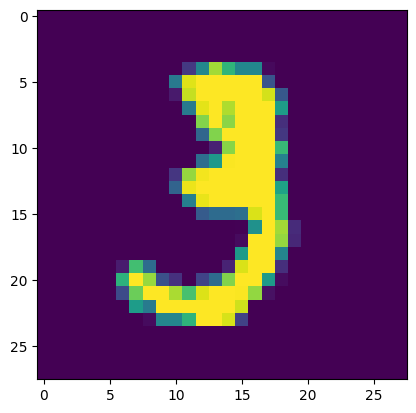

tensor(3)


In [8]:
# нарисуем, c чем мы имеем дело
import matplotlib.pyplot as plt

im_number = 10

# вот как хранятся изображения в компьютере
print(f"image:\n{X_train[im_number, :, :]}")

# а так их видим мы
plt.imshow(X_train[im_number, :, :])

plt.show()
print(y_train[im_number])

In [9]:
# посмотртим тип "картинок"
type(X_train[10, :, :])

torch.Tensor

In [10]:
X_train.shape

torch.Size([60000, 28, 28])

In [11]:
# unsqueeze - Возвращает новый тензор с увеличенной на 1 размерностью, которая вставляется в указанную позицию.
# было torch.Size([60000, 28, 28])  ---- станет torch.Size([60000, 1, 28, 28])
# и все значения - во float

X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [12]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [13]:
X_test.shape

torch.Size([10000, 1, 28, 28])

In [14]:
# Определяем класс, которые и будет представлять нашу нейронку
# какие слои - см описание вначале блокнота

class LeNet5(torch.nn.Module):
    # конструктор. Определям вообще какие слои у нас будут
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()

        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()

        self.fc3   = torch.nn.Linear(84, 10)

    # наша самая главная функция. Определяем, что и в каком порядке будет вызываться
    def forward(self, x):

        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)

        return x

# переменная - наша нейронка
lenet5 = LeNet5()

In [15]:
# определяем, где будет обучаться наша СNN
# если есть граф процессор от Nvidia, то на нем. Если нет, то на cpu

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = "cpu"

# отправляем туда нашу нейронку
lenet5 = lenet5.to(device)

# ЕСЛИ ВЫ ОБУЧИТЕ НЕЙРОНКУ НА GPU или CPU ОНА ДЛЯ СВОЕЙ РАБОТЫ БУДЕТ ТРЕБОВАТЬ ИЛИ GPU, ИЛИ CPU
Поэтому не всегда возможно использование обучения на GPU просто потому, что сервер или компьютер пользователя не будет поддерживать расчеты на GPU

In [16]:
# в качестве функции потерь будем использовать CrossEntropyLoss()
loss = torch.nn.CrossEntropyLoss()

# в качестве оптимайзера, который будет вычислять градиенты и минимизировать функцию потерь, будем использовать Adam (Адаптивная оценка момента)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [17]:
# будем оптимизировать по 100 параметров одним комплектом (бачем)
batch_size = 100

# чтобы посмотреть, как и что у нас тут менялось при оптимизации на тестовой выборке
test_accuracy_history = []
test_loss_history = []


train_loss_history = []

# не забываем отправить все выборки на устройство, на котором обучаем
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(100):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        # обязательно обнуляем градиенты
        optimizer.zero_grad()

        # берем пачку параметров
        batch_indexes = order[start_index:start_index+batch_size]

        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        # делаем предсказание
        preds = lenet5.forward(X_batch)

        # считаем лосс значение
        loss_value = loss(preds, y_batch)

        # берем градиенты
        loss_value.backward()

        # и пусть оптимайзер все оптимизирует
        optimizer.step()

    # смотрим, что он тут нам напредсказывал, не забывая вовремя отправлять на cpu
    train_loss_history.append(loss_value.data.cpu())

    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())


    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)

    print(f"epoch{epoch} - accuracy test {accuracy} ")

epoch0 - accuracy test 0.9757000207901001 
epoch1 - accuracy test 0.9807999730110168 
epoch2 - accuracy test 0.9861999750137329 
epoch3 - accuracy test 0.9883000254631042 
epoch4 - accuracy test 0.9872000217437744 
epoch5 - accuracy test 0.9876999855041504 
epoch6 - accuracy test 0.9865999817848206 
epoch7 - accuracy test 0.9872000217437744 
epoch8 - accuracy test 0.9890000224113464 
epoch9 - accuracy test 0.987500011920929 
epoch10 - accuracy test 0.9890999794006348 
epoch11 - accuracy test 0.9861000180244446 
epoch12 - accuracy test 0.9883999824523926 
epoch13 - accuracy test 0.9897000193595886 
epoch14 - accuracy test 0.9894000291824341 
epoch15 - accuracy test 0.9897000193595886 
epoch16 - accuracy test 0.9883999824523926 
epoch17 - accuracy test 0.9886999726295471 
epoch18 - accuracy test 0.9878000020980835 
epoch19 - accuracy test 0.987500011920929 
epoch20 - accuracy test 0.9883999824523926 
epoch21 - accuracy test 0.9889000058174133 
epoch22 - accuracy test 0.9886000156402588 


/tmp/ipykernel_1297050/422858666.py:3: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


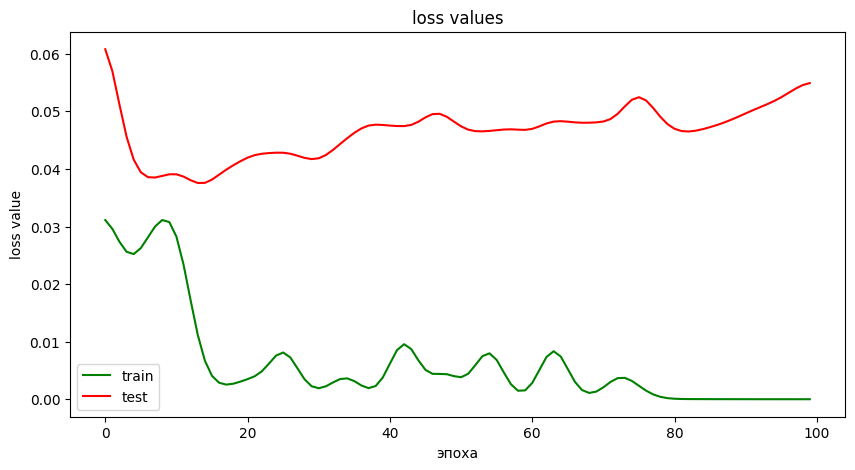

In [18]:
# строим графики - функции потерь

from scipy.ndimage.filters import gaussian_filter1d
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.set(title = 'loss values',
       xlabel = 'эпоха',
       ylabel = 'loss value')
train_loss_smoothed = gaussian_filter1d(train_loss_history, sigma=2)
ax.plot(train_loss_smoothed, color='green',  label='train')

test_loss_smoothed = gaussian_filter1d(test_loss_history, sigma=2)
ax.plot(test_loss_smoothed, color='red',  label='test')
ax.legend()
plt.show()



/tmp/ipykernel_1297050/2679742005.py:3: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


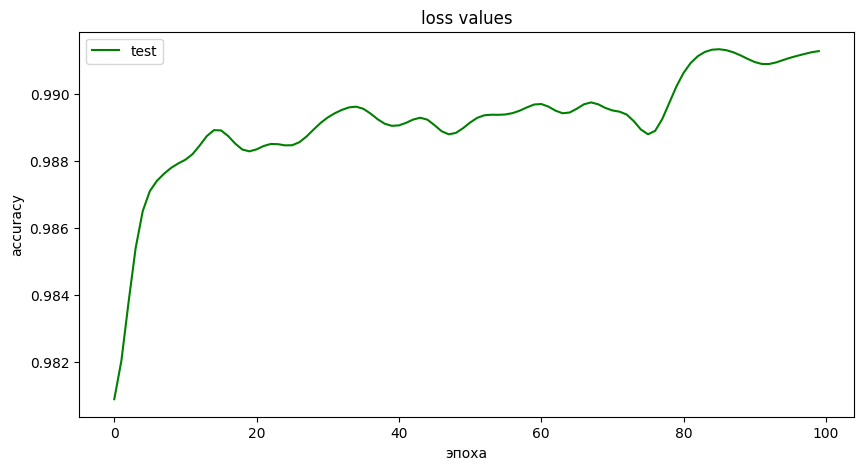

In [19]:
# График изменения accuracy на тестовых данных

from scipy.ndimage.filters import gaussian_filter1d
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.set(title = 'loss values',
       xlabel = 'эпоха',
       ylabel = 'accuracy')
test_accuracy_smoothed = gaussian_filter1d(test_accuracy_history, sigma=2)
ax.plot(test_accuracy_smoothed, color='green',  label='test')

ax.legend()
plt.show()


# Сохранение и использование модели

In [20]:
# сохраняем произвольное число из датасета (тензор) в файл
timg = X_train[0]

torch.save(timg,'tensor.pt')


In [21]:
# смотрим размер тензора - изображения
timg.size()

torch.Size([1, 28, 28])

In [22]:
# и размер того, что изначально скармливали нейронке.
# тензор подобного размера надо будет скормить нейронке для предсказания

X_test.size()

# то есть нам нужен тензор размера [1,1,28,28]

torch.Size([10000, 1, 28, 28])

In [23]:
!pip install dill

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 537.0 kB/s eta 0:00:00 0:00:01


In [24]:
# вот так сохраняют модель с помощью dill
import dill

with open("model.dill", "wb") as dill_file:
    dill.dump(lenet5, dill_file)


In [25]:
# вот так сохраняют модель с помощью pickle
import pickle

with open("model.pickle", "wb") as pickle_file:
    pickle.dump(lenet5, pickle_file)



In [26]:
# считываем модель, сохраненную в dill

ifile = open("model.dill", "rb")
modelp = dill.load(ifile)
ifile.close()

# загружаем наше изображение
test_data = torch.load('tensor.pt')

# смотрим, что пришло из dill файла
print(modelp)


LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act1): Tanh()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (act2): Tanh()
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (act3): Tanh()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (act4): Tanh()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [27]:
# смотрим тип модели
type(modelp)

__main__.LeNet5

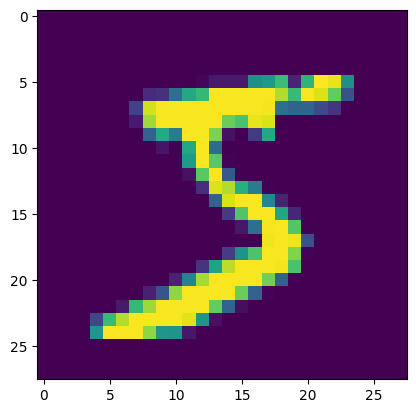

In [28]:
# смотрим, что за цифру считали
plt.imshow(test_data[0, :, :])
plt.show()

In [29]:
# переводим входной тензор-изображение в тензор нужного нам размера
t_data = torch.tensor([test_data.numpy()])

/tmp/ipykernel_1297050/3192455546.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  t_data = torch.tensor([test_data.numpy()])


In [30]:
# проверяем
t_data.shape

torch.Size([1, 1, 28, 28])

In [31]:
# проверяем, на чем можем считать
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# отправляем туда модель
modelp.to(dev)
model_data = modelp.to(dev)

# тензор-изображение тоже
t_data = t_data.to(dev)

In [32]:
# делаем предсказание
preds = modelp.forward(t_data)

In [33]:
# в каком виде получаем предсказание. Это вектор 10x1 с вероятностями принадлежности объекта к определенному классу
print(preds)

tensor([[ -1.3044,  -7.9593, -13.6442,   5.8792,  -5.8600,  27.6021,  -0.8007,
          -5.8889,  -0.2641,  -1.3229]], grad_fn=<AddmmBackward0>)


In [34]:
# выбираем максимальную вероятность, как результат предсказания.
# Не забывая отправить на cpu
prediction = np.argmax(preds.to('cpu').detach().numpy(),axis=1)

In [35]:
# смотрим, что предсказалось
print(prediction)

[5]


Цифра предсказана верно.

**Упражнение. Выберите случайным образом изображение из тестового набора и сделайте предсказание для него.**

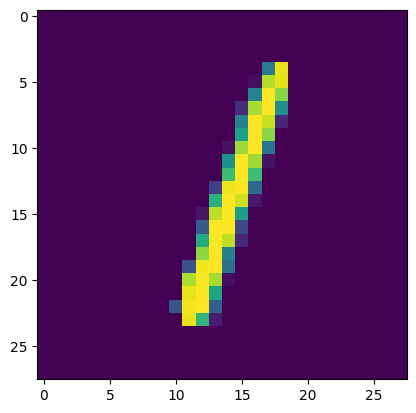

In [54]:
timg = X_test[random.randint(0,X_test.shape[0])]
if isinstance(timg, torch.Tensor):
    timg = timg.cpu().numpy() 
plt.imshow(timg[0, :, :])
plt.show()

In [55]:
t_data = torch.tensor([timg])
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
modelp.to(dev)
model_data = modelp.to(dev)
t_data = t_data.to(dev)
preds = modelp.forward(t_data)
prediction = np.argmax(preds.to('cpu').detach().numpy(),axis=1)
print(prediction)

[1]


***Задание. Реализовать классификацию изображений на своем датасете.***

1. Выберите датасет для классификации изображений https://pytorch.org/vision/stable/datasets.html
2. Определите архитектуру нейросети и приведите ее описание (текстом или иным способом) в своей работе
3. Реализуйте выбранную архитектуру в виде класса
4. Обучите нейросеть 
5. Постройте на одном графике кривые изменения функции потерь на тесте и обучении
6. Постройте график изменения выбранной метрики качества на тесте
7. Сохраните в файл одно изображение из тестовой выборки
8. Сохраните обученную нейросеть в файл
9. Загрузите изображение из файла
10. Загрузите нейросеть
11. Выполните предсказание с помощью загруженной из файла нейросети и оцените его правильность

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

1.

In [16]:
# Усиленные аугментации для тренировочных данных
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Простые преобразования для тестовых данных
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

classes = trainset.classes

2.
- Conv1: 3x3 свертка с 16 фильтрами + padding 1 + BatchNorm + ReLU
- MaxPool: 2x2 пулинг
- Conv2: 3x3 свертка с 32 фильтрами + padding 1 + BatchNorm + ReLU
- MaxPool: 2x2 пулинг
- Conv3: 3x3 свертка с 64 фильтрами + padding 1 + BatchNorm + ReLU
- MaxPool: 2x2 пулинг
- Linear1: 256 нейронов + ReLU + Dropout 0.25
- Linear2: 128 нейронов + ReLU + Dropout 0.25
- Linear3: 100 нейронов (выходной слой)

3.

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.dropout = nn.Dropout(0.25)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 100)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

net = SimpleCNN()

4.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

train_losses = []
test_losses = []
accuracies = []

for epoch in range(30):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    net.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    scheduler.step()
    
    train_loss = running_loss/len(trainloader)
    test_loss = test_loss/len(testloader)
    accuracy = 100*correct/total
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)

    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.3f}, '
          f'Test Loss: {test_loss:.3f}, Accuracy: {accuracy:.2f}%, '
          f'LR: {scheduler.get_last_lr()[0]:.6f}')


Epoch 1: Train Loss: 3.985, Test Loss: 3.520, Accuracy: 14.56%, LR: 0.001000
Epoch 2: Train Loss: 3.533, Test Loss: 3.122, Accuracy: 22.49%, LR: 0.001000
Epoch 3: Train Loss: 3.324, Test Loss: 3.005, Accuracy: 24.00%, LR: 0.001000
Epoch 4: Train Loss: 3.179, Test Loss: 2.859, Accuracy: 26.71%, LR: 0.001000
Epoch 5: Train Loss: 3.075, Test Loss: 2.753, Accuracy: 28.68%, LR: 0.001000
Epoch 6: Train Loss: 2.998, Test Loss: 2.635, Accuracy: 32.38%, LR: 0.001000
Epoch 7: Train Loss: 2.926, Test Loss: 2.593, Accuracy: 32.83%, LR: 0.001000
Epoch 8: Train Loss: 2.870, Test Loss: 2.575, Accuracy: 33.44%, LR: 0.001000
Epoch 9: Train Loss: 2.811, Test Loss: 2.469, Accuracy: 35.39%, LR: 0.001000
Epoch 10: Train Loss: 2.763, Test Loss: 2.399, Accuracy: 36.74%, LR: 0.001000
Epoch 11: Train Loss: 2.717, Test Loss: 2.369, Accuracy: 37.17%, LR: 0.001000
Epoch 12: Train Loss: 2.680, Test Loss: 2.394, Accuracy: 37.05%, LR: 0.001000
Epoch 13: Train Loss: 2.638, Test Loss: 2.299, Accuracy: 38.90%, LR: 0.00

5.

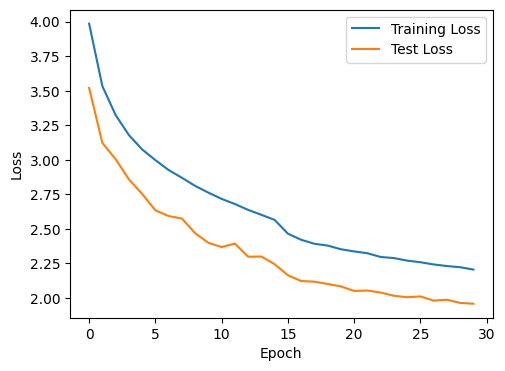

In [20]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

Модель слишком пережата, но в ином случае не получилось уйти от переобучения

6.

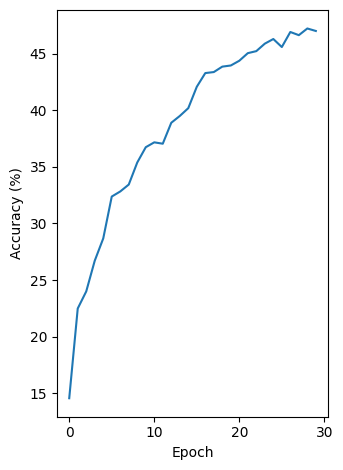

In [21]:

plt.subplot(1,2,2)
plt.plot(accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.tight_layout()
plt.savefig('metrics.png')
plt.show()

7-8

In [22]:
type(testset)

torchvision.datasets.cifar.CIFAR100

sea


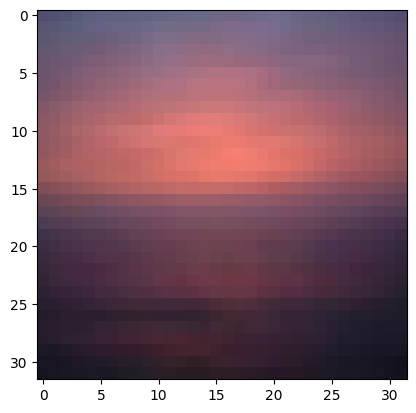

In [38]:
dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[4]
print(classes[(labels[4])])
img = img/2 + 0.5

npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))

torch.save(img,'tensor_img_scnn.pt')

import dill
with open("scnn.dill", "wb") as dill_file:
    dill.dump(net, dill_file)

9-11

In [39]:
test_tensor = torch.load('tensor_img_scnn.pt')
test_tensor = torch.tensor([test_tensor.numpy()])

ifile = open("scnn.dill", "rb")
loaded_net = dill.load(ifile)
ifile.close()
type(loaded_net)

loaded_net.eval()
with torch.no_grad():
    output = loaded_net(test_tensor)
    _, predicted = torch.max(output, 1)
    print(f'Predicted class: {classes[predicted[0]]}')

Predicted class: sea
